# 사용 패키지

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers datasets rouge_score kobart_transformers

     |████████████████████████████████| 3.1 MB 5.3 MB/s 
     |████████████████████████████████| 290 kB 42.1 MB/s 
     |████████████████████████████████| 596 kB 39.5 MB/s 
     |████████████████████████████████| 895 kB 40.2 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
     |████████████████████████████████| 3.3 MB 35.5 MB/s 
     |████████████████████████████████| 1.3 MB 34.6 MB/s 
     |████████████████████████████████| 125 kB 48.4 MB/s 
     |████████████████████████████████| 243 kB 45.8 MB/s 
     |████████████████████████████████| 271 kB 47.2 MB/s 
     |████████████████████████████████| 160 kB 45.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import pandas as pd
import numpy as np
import json
import os
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt

#from konlpy.tag import Mecab

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader,TensorDataset

from datasets import load_metric
from kobart_transformers import get_kobart_model, get_kobart_for_conditional_generation, get_kobart_tokenizer
from transformers import BartForConditionalGeneration

## hyperparameter

In [4]:
batch_size = 16
learning_rate = 1e-4
epochs = 1

device = torch.device("cuda:0")

## define metric

In [5]:
metric = load_metric("rouge")

Downloading:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

In [7]:
def rouge_function(labels,summary_ids,tar_tokenizer):
    
    pred_list = [tar_tokenizer.convert_tokens_to_string(tar_tokenizer.convert_ids_to_tokens(g.to('cpu').tolist(),skip_special_tokens=True)[1:-1]) for g in summary_ids]

    real_list = [tar_tokenizer.convert_tokens_to_string(tar_tokenizer.convert_ids_to_tokens(g.to('cpu').tolist(),skip_special_tokens=True)[1:-1]) for g in labels]

    result = metric.compute(predictions=pred_list,references=real_list)

    metric_result = {key:value.mid.fmeasure for key,value in result.items()}

    return metric_result['rouge1'],metric_result['rouge2'],metric_result['rougeL']

## load train data

In [8]:
DIR = "/content/drive/MyDrive/data/"
TRAIN_SOURCE = os.path.join(DIR, "train_original3.json")
VALID_SOURCE = os.path.join(DIR, "vaild_original3.json")

In [9]:
with open(TRAIN_SOURCE) as f:
    TRAIN_DATA = json.loads(f.read())
    
with open(VALID_SOURCE) as f:
    VALID_DATA = json.loads(f.read())

## create train data

In [9]:
train_document = TRAIN_DATA['documents']

len(train_document)

271093

## create data1

In [35]:
train = pd.DataFrame(columns=['id', 'context', 'extractive', 'summary'])

train_document = TRAIN_DATA['documents']

id = 0

for data in tqdm(train_document):
    
    id, abstractive, extractive, texts = data['id'], data['abstractive'], data['extractive'], data['text']

    context = ''

    extract_context = ''

    for text in texts[0]:
        context += text['sentence']

        if text['index'] in extractive:
            extract_context += text['sentence']
    

    train.loc[id, 'id'] = id
    train.loc[id, 'context'] = context
    train.loc[id, 'extractive'] = extract_context
    train.loc[id, 'summary'] = abstractive[0]

    id += 1

100%|██████████| 15000/15000 [01:45<00:00, 142.80it/s]


In [22]:
train.head()

,id,context,extractive,summary
345236344,345236344,김범수안산시의회 의원연구단체 현문답 팀이 의회 대회의실에서 공동주택 층간소음 분쟁해...,,안산시의회 의원연구단체'현문답'팀이 지난 14일 의회 대의원실에서 '층간소음이웃사이...
342918159,342918159,안인득 사건 이후 불안 확산 여파…사회적응 돕는 가정 개관 앞두고 금곡동 주민 “운...,,"정신질환자의 강력범죄·자해 등의 영향으로 사람들이 불안에 떨고 있는 가운데, 부산 ..."
364507062,364507062,자격증 교육기관 '한국장학진흥원'이 병원코디네이터 자격증 교육에 필요한 인강 수강료...,자격증 교육기관 '한국장학진흥원'이 병원코디네이터 자격증 교육에 필요한 인강 수강료...,한국장학진흥원이 병원코디네이터 자격증 교육에 필요한 인강 수강료와 시험 응시료를 선...
336606376,336606376,한국예탁결제원은 크라우드펀딩 성공기업 10개사와 함께 이스라엘 예루살렘에서 열린 '...,한국예탁결제원은 크라우드펀딩 성공기업 10개사와 함께 이스라엘 예루살렘에서 열린 '...,한국예탁결제원은 7일 이스라엘 예루살렘에서 개최 된 '2019 아워크라우드 글로벌 ...
303952095,303952095,"유아~성인, 다양한 목공체험 가능",,"지난 1일 백운산자연휴양림 내에 체험실, 전문 목공실, 놀이터, 전시실 등의 시설이..."


## create data3

In [10]:
train = pd.DataFrame(columns=['id', 'context', 'extractive', 'summary'])

#train_document = TRAIN_DATA['documents']

train_document = np.random.choice(TRAIN_DATA['documents'],15000)

id = 0

for data in tqdm(train_document):
    
    abstractive, extractive, texts = data['abstractive'], data['extractive'], data['text']

    context = ''

    extract_context = ''

    for text in texts:
        for sentence in text:
            context += sentence['sentence']

            if sentence['index'] in extractive:
                extract_context += sentence['sentence']
    

    train.loc[id, 'id'] = id
    train.loc[id, 'context'] = context
    train.loc[id, 'extractive'] = extract_context
    train.loc[id, 'summary'] = abstractive[0]

    id += 1

100%|██████████| 15000/15000 [00:40<00:00, 368.27it/s]


In [11]:
train.head()

,id,context,extractive,summary
0,0,신세계아이앤씨가 경기 김포 데이터센터에 국내 최초의 자동결제 셀프매장을 선보인다.모...,"신세계아이앤씨(대표 김장욱)는 경기 김포 데이터센터에 미래형 셀프매장을 구축, 임직...",신세계아이앤씨는 경기 김포 데이터센터에 국내 최초로 자동결제 기술인 '저스트 워크 ...
1,1,8월 초 급락세를 딛고 중화권 지수가 반등하면서 이와 연동되는 중국 상장지수펀드(E...,8월 초 급락세를 딛고 중화권 지수가 반등하면서 이와 연동되는 중국 상장지수펀드(E...,8월 초 급락세를 딛고 중화권 지수가 반등하면서 홍콩 시위 장기화에 따른 금융시장 ...
2,2,한국경제신문과 한경닷컴이 오는 26일 서울 논현동 건설회관에서 '2019 부동산 시...,한국경제신문과 한경닷컴이 오는 26일 서울 논현동 건설회관에서 '2019 부동산 시...,28일 논현동 건설회관에서 아파트 가격에 대한 다양한 견해를 가진 전문가들이 초청되...
3,3,부대 차원 환영행사 개최…수령절차 거쳐 4~5월께 전력화연말까지 10여대 도착할듯…...,우리 공군이 운용하게 될 스텔스 전투기 F-35A 2대가 29일 오후 2시 청주 공...,우리 공군이 미국 현지에서 인수한 스텔스 전투기 F-35A 6대 중 2대가 29일...
4,4,[부산=환경일보] 권영길 기자 = 부산시교육청은 부산지역 모든 초등학교 1학년 학생...,[부산=환경일보] 권영길 기자 = 부산시교육청은 부산지역 모든 초등학교 1학년 학생...,"부산교육청은 초등학교 1학년 학생들에게 가방 안전덮개 3만개를 공급하였으며, 이는 ..."


In [26]:
train['summary'][0]

'지난 28일 민주노총 건설노조 울산건설기계지부 간부들이 레미콘 운송료 인상을 요구하며 고공 농성에 돌입한 가운데 4만5000원에서 5만원으로 운송료를 인상해달라고 요구했으나 이를 거부하자 파업에 돌입했다.'

In [28]:
valid_document = VALID_DATA['documents']

len(valid_document)

30122

In [12]:
valid = pd.DataFrame(columns=['id', 'context', 'extractive', 'summary'])

#train_document = TRAIN_DATA['documents']

valid_document = np.random.choice(TRAIN_DATA['documents'],1500)

id = 0

for data in tqdm(valid_document):
    
    abstractive, extractive, texts = data['abstractive'], data['extractive'], data['text']

    context = ''

    extract_context = ''

    for text in texts:
        for sentence in text:
            context += sentence['sentence']

            if sentence['index'] in extractive:
                extract_context += sentence['sentence']
    

    valid.loc[id, 'id'] = id
    valid.loc[id, 'context'] = context
    valid.loc[id, 'extractive'] = extract_context
    valid.loc[id, 'summary'] = abstractive[0]

    id += 1

100%|██████████| 1500/1500 [00:02<00:00, 672.46it/s]


In [13]:
valid.head()

,id,context,extractive,summary
0,0,편의점 CU를 운영하는 BGF리테일이 중소협력사와 함께 '2019 하반기 한마음 힐...,편의점 CU를 운영하는 BGF리테일이 중소협력사와 함께 '2019 하반기 한마음 힐...,25일 편의점 CU를 운영하는 BGF리테일이 2014년부터 중소협력사와의 소통을 위...
1,1,데이터 교통량 폭증시키는데 설비증설 부담은 통신사에망 사용료 내면서 경쟁해야 하는 ...,최근 구글(유튜브)이나 넷플릭스 같은 글로벌 콘텐츠 사업자(이하 CP)가 국내에서 ...,최근 글로벌 콘텐츠 사업자(이하 CP)가 국내에서 영향력이 커지면서 국내에서도 안...
2,2,유정희인천시교육청이 과밀학급 해소를 위해 교육부에 '학교신설 기준' 등 제도개선을 ...,인천시교육청이 과밀학급 해소를 위해 교육부에 '학교신설 기준' 등 제도개선을 촉구하...,인천시 교육청은 신도시 학생들이 과도하게 모여 학습권을 침해받고 있다고 판단해 16...
3,3,현대제철이 올해 3분기 중국 사업 부진과 원자재 가격을 제때 반영하지 못하면서 증권...,현대제철이 올해 3분기 중국 사업 부진과 원자재 가격을 제때 반영하지 못하면서 증권...,현대제철이 증권가 전망치를 훨씬 밑도는 '어닝 쇼크'를 기록하면서 원가절감 등 '마...
4,4,[이데일리 노희준 기자] '밀실협정' 논란이 제기됐던 한일 군사정보보호협정의 협상 ...,대법원 제1부(주심 박정화 대법관)은 참여연대가 외교부를 상대로 낸 정보공개거부 취...,정부가 지난 2012년 6월 비공개 국무회의에서 통과시킨 한일 군사정보보호협정에 대...


In [14]:
train.shape , valid.shape

((15000, 4), (1500, 4))

## tokenizing using kobart

In [15]:
kobart_tokenizer = get_kobart_tokenizer()

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/109 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/666k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BartTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


In [16]:
train_src = kobart_tokenizer(list(train.context), padding=True, truncation=True, max_length=500)
val_src = kobart_tokenizer(list(valid.context), padding=True, truncation=True, max_length=500)

train_tar = kobart_tokenizer(list(train.summary), padding=True, truncation=True, max_length=50)
val_tar = kobart_tokenizer(list(valid.summary), padding=True, truncation=True, max_length=50)

In [17]:
len(train_src['input_ids'])

15000

## create torch dataset

In [18]:
class CustomDataset(Dataset):
    def __init__(self, src_tokens, tar_tokens, mode='train'):
        self.mode = mode
        self.src_tokens = src_tokens
        if self.mode == 'train':
            self.tar_tokens = tar_tokens
            
    def __len__(self):
        return len(self.src_tokens)
    
    def __getitem__(self, i):
        src_token = self.src_tokens[i]
        if self.mode == 'train':
            tar_token = self.tar_tokens[i]
            return {
                'src_token' : torch.tensor(src_token, dtype=torch.long),
                'tar_token' : torch.tensor(tar_token, dtype=torch.long),
            }
        else:
            return {
                'src_token' : torch.tensor(src_token, dtype=torch.long)
            }

In [19]:
train_dataset = CustomDataset(train_src['input_ids'], train_tar['input_ids'])
val_dataset = CustomDataset(val_src['input_ids'], val_tar['input_ids'])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=2, shuffle=False)

## load kobart model

In [ ]:
model = get_kobart_for_conditional_generation()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## model train

In [20]:
# load trained model

model = BartForConditionalGeneration.from_pretrained('/content/drive/MyDrive/data/model.pt')

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
def train_step(model, batch_item, batch, training):
    input_ids = batch_item['src_token'].to(device)
    labels = batch_item['tar_token'].to(device)

    inputs = {'input_ids':input_ids,
                       'labels':labels}
  
    model.to(device)
    
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            loss = model(**inputs).loss
            
            summary_ids = model.generate(input_ids, num_beams=4, early_stopping=True)

            rouge1,rouge2,rougeL = rouge_function(labels,summary_ids,kobart_tokenizer)

        loss.backward()
        optimizer.step()
        lr = optimizer.param_groups[0]["lr"]
        return loss, rouge1,rouge2,rougeL, round(lr, 10)
    else:
        model.eval()
        with torch.no_grad():
            loss = model(**inputs).loss

            summary_ids = model.generate(input_ids, num_beams=4, early_stopping=True)

            rouge1,rouge2,rougeL = rouge_function(labels,summary_ids,kobart_tokenizer)

        return loss, rouge1,rouge2,rougeL

In [22]:
loss_plot, val_loss_plot = [], []
total_rouge1_plot, total_rouge2_plot, total_rougeL_plot = [] , [] , []
total_val_rouge1_plot, total_val_rouge2_plot, total_val_rougeL_plot = [] , [] , []

for epoch in range(epochs):
    gc.collect()
    total_loss, total_val_loss = 0, 0

    total_rouge1, total_rouge2, total_rougeL = 0,0,0

    total_val_rouge1, total_val_rouge2, total_val_rougeL = 0,0,0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss, rouge1,rouge2,rougeL, lr = train_step(model, batch_item, batch, training)
        total_loss += batch_loss
        total_rouge1 += rouge1
        total_rouge2 += rouge2
        total_rougeL += rougeL
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'LR' : lr,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Total Loss' : '{:06f}'.format(total_loss/(batch+1)),
            'Total Rouge1' : total_rouge1/(batch+1), 'Total Rouge2' : total_rouge2/(batch+1), 'Total RougeL' : total_rougeL/(batch+1)
        })
    loss_plot.append(total_loss/(batch+1))
    total_rouge1_plot.append(total_rouge1/(batch+1)) 
    total_rouge2_plot.append(total_rouge2/(batch+1))
    total_rougeL_plot.append(total_rougeL/(batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss, rouge1,rouge2,rougeL  = train_step(model, batch_item, batch, training)
        total_val_loss += batch_loss
        total_val_rouge1 += rouge1
        total_val_rouge2 += rouge2
        total_val_rougeL += rougeL
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Total Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
            'Total Rouge1' : total_val_rouge1/(batch+1), 'Total Rouge2' : total_val_rouge2/(batch+1), 'Total RougeL' : total_val_rougeL/(batch+1)
          
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    total_val_rouge1_plot.append(total_val_rouge1/(batch+1)) 
    total_val_rouge2_plot.append(total_val_rouge2/(batch+1))
    total_val_rougeL_plot.append(total_val_rougeL/(batch+1))

938it [2:50:56, 10.93s/it, Epoch=1, LR=0.0001, Loss=1.375162, Total Loss=1.617641, Total Rouge1=0.277, Total Rouge2=0.0877, Total RougeL=0.272]
94it [04:06,  2.62s/it, Epoch=1, Val Loss=1.466393, Total Val Loss=1.500089, Total Rouge1=0.313, Total Rouge2=0.0901, Total RougeL=0.305]


In [23]:
# save trained model

model.save_pretrained('/content/drive/MyDrive/data/model2.pt')

## visualization

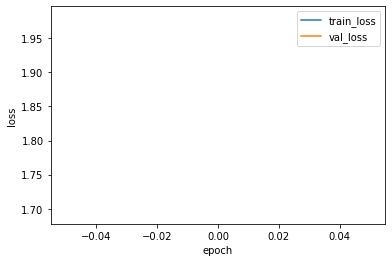

In [ ]:
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

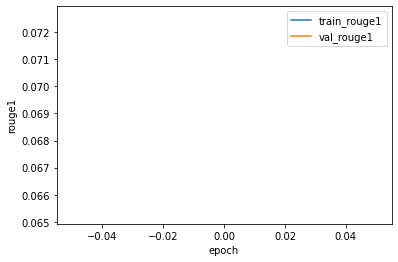

In [ ]:
plt.plot(total_rouge1_plot, label='train_rouge1')
plt.plot(total_val_rouge1_plot, label='val_rouge1')
plt.xlabel('epoch')
plt.ylabel('rouge1')
plt.legend()
plt.show()

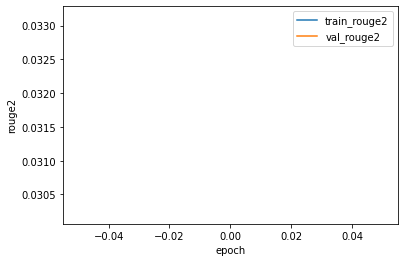

In [ ]:
plt.plot(total_rouge2_plot, label='train_rouge2')
plt.plot(total_val_rouge2_plot, label='val_rouge2')
plt.xlabel('epoch')
plt.ylabel('rouge2')
plt.legend()
plt.show()

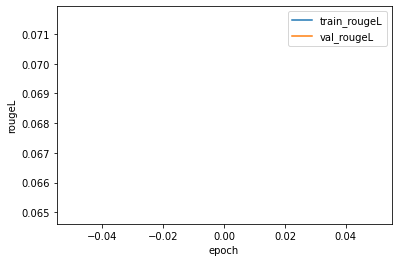

In [ ]:
plt.plot(total_rougeL_plot, label='train_rougeL')
plt.plot(total_val_rougeL_plot, label='val_rougeL')
plt.xlabel('epoch')
plt.ylabel('rougeL')
plt.legend()
plt.show()

# 평가 데이터 로드

In [24]:
with open('/content/test.jsonl', "r", encoding="utf-8") as f:
    jsonl = list(f)

test_data = []
for json_str in jsonl:
    test_data.append(json.loads(json_str))
    
submission = pd.read_csv('/content/sample_submission.csv')

In [25]:
test_data[0]

{'article_original': ['한국은행이 지난달 기준금리를 추가 인하한 영향으로 대출금리가 일제 하락했다.',
  '특히 기업대출금리는 1996년 관련 통계 집계 이후 가장 낮은 수준까지 하락했다.',
  "한국은행이 28일 발표한 '2019년 10월 중 금융기관 가중평균금리'에 따르면 신규취급액 기준 지난달 예금은행의 대출평균금리는 연 3.20%로 전월 대비 0.11%포인트 하락했다.",
  '대출금리를 기업과 가계로 나눠보면 기업대출금리 하락폭이 가팔랐다.',
  '10월 기업대출금리는 연 3.28%로 전월 대비 0.14%포인트 떨어졌다.',
  '연 3.28%는 1996년 1월 관련 통계 작성 이후 최저치다.',
  '대기업의 경우 기준이 되는 단기지표 금리의 하락 영향으로 10월 대출금리가 연 3.13%로 전월 대비 0.17%포인트 빠졌다.',
  '중소기업은 일부 은행의 저금리 대출 취급 등의 영향으로 연 3.39%로 0.11%포인트 하락했다.',
  '한은 관계자는 "지난달 기준금리가 인하되면서 단기 지표에 영향을 많이 받는 기업대출 금리도 역대 최저 수준으로 하락했다"고 설명했다.',
  '같은 기간 가계대출 금리도 하락했다.',
  '10월 가계대출 금리는 연 3.01%로 전월 대비 0.01%포인트 하락했다.',
  '같은 기간 주택담보대출 금리도 연 2.50%로 0.01%포인트 떨어졌다.',
  '가계대출 금리의 경우 기업대출에 비해 장기지표 영향을 많이 받아 하락폭은 작았다.',
  '한편 10월 중 비은행금융기관 예금금리(1년만기 정기예탁금 기준)는 모두 하락했고 대출금리(일반대출 기준)는 상호저축은행은 상승, 상호금융은 하락했다.'],
 'id': '368851881',
 'media': '아시아경제'}

## create test dataset

In [26]:
test = pd.DataFrame(columns=['id', 'context'])

for data in tqdm(test_data):
    
    id, texts = data['id'], data['article_original']

    context = ''

    for text in texts:
        context += text
    
    test.loc[id, 'id'] = id
    test.loc[id, 'context'] = context

100%|██████████| 4161/4161 [00:06<00:00, 676.47it/s]


In [27]:
test.head()

,id,context
368851881,368851881,한국은행이 지난달 기준금리를 추가 인하한 영향으로 대출금리가 일제 하락했다.특히 기...
368352503,368352503,나기복 대한민국 무공수훈자회 사무국장 / 충남 장례선양단 팀장우리 충남장례선양단 지...
363605040,363605040,"1929년 12월26일자 ‘180명 체포’ 등 3차례 보도동경주재기자, 일본정부 통..."
352052205,352052205,백주희문재인 대통령은 9일 공공분야를 중심으로 한 공정문화 확산의 중요성을 강조했다...
338689235,338689235,"5개 구장 중 4개 구장서 매진, 하루 최다 기록엔 58명 모자라2019년 프로야구..."


In [28]:
test_src = kobart_tokenizer(list(test.context), padding=True, truncation=True, max_length=500)

test_dataset = CustomDataset(test_src['input_ids'], None, 'test')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=2, shuffle=False)

## 요약문 생성 및 제출

자연어 생성 모델을 베이스라인으로 제공하기에 장시간의 학습시간을 필요로 하여 간단한 규칙기반 요약문 생성하였습니다.

BART, GPT 등 자연어 생성 모델을 활용을 추천드리고 베이스라인은 데이터로드 부터 제출하는 과정의 용도로 참고해주시기 바랍니다.

In [29]:
def evaluate(model, tar_tokenizer, tokens):

    summary_ids = model.generate(tokens, num_beams=4, early_stopping=True)

    pred_list = [tar_tokenizer.convert_tokens_to_string(tar_tokenizer.convert_ids_to_tokens(g.to('cpu').tolist(), skip_special_tokens=True)[1:-1]) for g in summary_ids]

    return pred_list

In [30]:
tqdm_dataset = tqdm(enumerate(test_dataloader))

preds = []

model.eval()

with torch.no_grad():

    for batch, batch_item in tqdm_dataset:
        output = evaluate(model, kobart_tokenizer, batch_item['src_token'].to(device))
        preds.extend(output)

261it [07:17,  1.67s/it]


In [31]:
for data,pred in zip(test_data,preds):
    did = int(data['id'])
    idx = submission[submission['id']==did].index
    submission.loc[idx, 'summary'] = pred

In [32]:
submission

,id,summary
0,250366726,당진축협 사료공장 신축이 추진 중인 송악읍 가학리 2
1,251994086,"남송 채규선 작가가 지난달 10일 당진문화재단 출판기념회를 갖고, '"
2,252639804,아산시가 고향인 정상열 주무관은 지난 2002년부터 2년 동안 당진에서 군
3,252639915,진옥성결교회 교인 28명이 지난 16일부터 21일까지 스리랑카 보
4,253427793,"당진시는 청년 문제를 결혼, 출산, 노인부양 등으로 이어지는 보편적 사회문제로"
...,...,...
4156,372705621,울산경찰청은 31일 자정을 기준으로 '2020년 운전면허 행정처분 특별감
4157,372751633,"배기성은 12월 31일 방송된 KBS 1TV 'TV는 사랑을 싣고'에 출연해 """
4158,372770123,제주관광공사가 31일 발표한 '관광객 신용카드 매출 빅데이터 지역별 분석' 자료에 ...
4159,372779075,"임실군 애향 장학회에 전달된 기탁금은 총 1억9,240"


In [33]:
submission.to_csv('/content/baseline.csv', index=False)